In [1]:
# Basic libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib tk

In [2]:
# tkinter GUI import
import tkinter as tk1
from tkinter.filedialog import askopenfilename

In [3]:
# Debugger import library if required
from IPython.core.debugger import set_trace

In [4]:
# Import filename interactively
root = tk1.Tk()
root.lift()
root.attributes("-topmost", True)
root.withdraw()
filename = askopenfilename()
root.destroy()

In [5]:
filename

'D:/Projects/App/Daily_dump/10062020/MB1A3GCD4KRYD3435_2020-6-10_2020-06-12.csv'

In [44]:
# Read the raw dataframe and read 'obu_timestamp' column as datetime format
data = pd.read_csv(filename,
                   parse_dates=['obu_timestamp'])

In [45]:
# Add an index column to the created dataframe
data.reset_index(level=0, inplace=True)

In [46]:
# Verify dataframe dtypes and column entries
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4794 entries, 0 to 4793
Columns: 120 entries, index to fuel_level
dtypes: datetime64[ns](1), float64(57), int64(58), object(4)
memory usage: 4.4+ MB


In [47]:
# Peep into the first 5 lines of data
data.head(5)

,index,S_No,obu_id,obu_timestamp,packet_sequence_id,p_frequency,latitude,longitude,altitude,heading,...,aft1_intake_nox,aft1_intake_nox_reading_stable,aft1_intermediate_gas,dpf1_regen_needed,low_adblue_level_warning,eng_requested_torque_limit,pf_actreginh_dueto,aftertreatment1_outlet_nox,vin,fuel_level
0,0,1,2001221048,2020-06-10 01:15:00,32339,6,29.933541,77.048846,240.69,0.0,...,0.0,3,0.1,0,0,-125,0,0.0,MB1A3GCD4KRYD3435,92.5
1,1,2,2001221048,2020-06-10 01:15:06,32340,6,29.933541,77.048846,240.69,0.0,...,0.0,3,0.1,0,0,-125,0,0.0,MB1A3GCD4KRYD3435,92.5
2,2,3,2001221048,2020-06-10 01:15:12,32341,6,29.933541,77.048846,240.69,0.0,...,0.0,3,0.1,0,0,-125,0,0.0,MB1A3GCD4KRYD3435,92.5
3,3,4,2001221048,2020-06-10 01:15:18,32342,6,29.933541,77.048846,240.69,0.0,...,0.0,3,0.1,0,0,-125,0,0.0,MB1A3GCD4KRYD3435,92.5
4,4,5,2001221048,2020-06-10 01:15:24,32343,6,29.933541,77.048846,240.69,0.0,...,0.0,3,0.1,0,0,-125,0,0.0,MB1A3GCD4KRYD3435,92.5


In [48]:
#data['BSFC_rating'] = 0

In [49]:
# BSFC zone rating
for rows in data.index: # loops through entire dataframe based on size
    #set_trace()
    ##
    if(data.engine_speed.iloc[rows]>2300):
        data.at[rows,'BSFC_rating'] = 1
    ##
    if((data.engine_speed.iloc[rows] < 2300) & 
       (data.engine_speed.iloc[rows] > 2100) &
       (data.actual_engine_percent_torque.iloc[rows] > 40)):
        data.at[rows,'BSFC_rating'] = 3
    if((data.engine_speed.iloc[rows] < 2300) & 
       (data.engine_speed.iloc[rows] > 2100) &
       (data.actual_engine_percent_torque.iloc[rows] < 40)):
        data.at[rows,'BSFC_rating'] = 1
    ##
    if((data.engine_speed.iloc[rows] < 2100) & 
       (data.engine_speed.iloc[rows] > 1900) &
       (data.actual_engine_percent_torque.iloc[rows] > 40)):
        data.at[rows,'BSFC_rating'] = 4
    if((data.engine_speed.iloc[rows] < 2100) & 
       (data.engine_speed.iloc[rows] > 1900) &
       (data.actual_engine_percent_torque.iloc[rows] < 40)):
        data.at[rows,'BSFC_rating'] = 1
    ##
    if((data.engine_speed.iloc[rows] < 1900) & 
       (data.engine_speed.iloc[rows] > 1200) &
       (data.actual_engine_percent_torque.iloc[rows] > 60)):
        data.at[rows,'BSFC_rating'] = 5
    if((data.engine_speed.iloc[rows] < 1900) & 
       (data.engine_speed.iloc[rows] > 1200) &
       (data.actual_engine_percent_torque.iloc[rows] < 60) &
       (data.actual_engine_percent_torque.iloc[rows] > 40)):
        data.at[rows,'BSFC_rating'] = 4
    if((data.engine_speed.iloc[rows] < 1900) & 
       (data.engine_speed.iloc[rows] > 1200) &
       (data.actual_engine_percent_torque.iloc[rows] < 40)):
        data.at[rows,'BSFC_rating'] = 1
    ##
    if((data.engine_speed.iloc[rows] < 1200) & 
       (data.engine_speed.iloc[rows] > 1000) &
       (data.actual_engine_percent_torque.iloc[rows] > 40)):
        data.at[rows,'BSFC_rating'] = 3
    if((data.engine_speed.iloc[rows] < 1200) & 
       (data.engine_speed.iloc[rows] > 1000) &
       (data.actual_engine_percent_torque.iloc[rows] < 40)):
        data.at[rows,'BSFC_rating'] = 1
    ##
    if((data.engine_speed.iloc[rows] < 1000) &
       (data.actual_engine_percent_torque.iloc[rows] > 40)):
        data.at[rows,'BSFC_rating'] = 2
    if((data.engine_speed.iloc[rows] < 1000) & 
       (data.actual_engine_percent_torque.iloc[rows] < 40) & 
       (data.actual_engine_percent_torque.iloc[rows] > 20)):
        data.at[rows,'BSFC_rating'] = 1
    if((data.engine_speed.iloc[rows] < 1000) & 
       (data.actual_engine_percent_torque.iloc[rows] < 20)):
        data.at[rows,'BSFC_rating'] = 3

In [50]:
#data['acceleration_6s']=0.00

In [51]:
for rows in data.index[1:]:
    #set_trace()
    acc = (data.wheel_based_speed.iloc[rows]*5/18 - data.wheel_based_speed.iloc[rows-1]*5/18)/(data.obu_timestamp.iloc[rows].second - data.obu_timestamp.iloc[rows-1].second)
    data.at[rows, 'acceleration_6s'] = acc

C:\Users\devanandh.v\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\devanandh.v\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


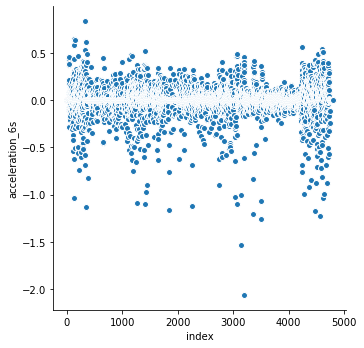

In [52]:
sns.pairplot(data,x_vars='index',y_vars='acceleration_6s',size=5)

In [53]:
# Check total instances of Igntion On and OFF
data['ignition_status'].value_counts()

1    4456
0     338
Name: ignition_status, dtype: int64

In [54]:
#-----------------------------
### No. of trips extractor 

# Variable initilization
trip_id = 1 
trip_info_list = [] 
start_index = 0 
stop_index = 0 
rows = 0 
x = 0 

for rows in data.index: # loops through entire dataframe based on size
    
        for rows in data.index[start_index:]:          # Loop through the subdataframe starting with the latest start index
            #set_trace()                               # Debugging sequence if reqd remove '#' and run for line by line debugging
            if(data['ignition_status'].iloc[rows] == 1): # Enter loop if Ingition ON is detected
                start_index = data['index'].iloc[rows]   # Assign the first index of satisfied condition for Ignition ON
                for x in data.index[rows:]:              # For this loop sequence determining the next instance of Ignition OFF
                    if(data['ignition_status'].iloc[x] == 0): # Stop at instance when Ignition is detected OFF
                        stop_index = data['index'].iloc[x]    # Store the index as latest stop index
                        break 
                if(start_index<=stop_index):                  # Proceed only if stop index is greater than start index
                    trip_info_temp=[trip_id,start_index,stop_index] # Temporary row list containing parameters
                    trip_info_list.append(trip_info_temp)     # Append to the trip info list
                    start_index=stop_index                   # Assign the latest stop index as the next start index to initiate next subdataframe
                    trip_id +=1 
                else:                                        # Force exit the entire loop, if start index greater than stop index, indicating the source dataframe does not end with Ignition OFF
                    break
                break 

print(trip_info_list)  # list all trip info in the current dataset

# ---------------------------

[[1, 0, 17], [2, 37, 403], [3, 423, 479], [4, 500, 557], [5, 577, 596], [6, 616, 684], [7, 704, 740], [8, 761, 770], [9, 790, 798], [10, 817, 891], [11, 911, 941], [12, 960, 973], [13, 991, 1012], [14, 1032, 1048], [15, 1068, 1099], [16, 1119, 2059], [17, 2079, 4774]]


In [137]:
trip_info_df = pd.DataFrame(trip_info_list,
                            columns=['Trip_ID', "Start_index", "Stop_index"
                                     ])  # Convert list to dataframe

In [138]:
trip_info_df.head(5) # Trip_info dataframe view

,Trip_ID,Start_index,Stop_index
0,1,0,17
1,2,37,403
2,3,423,479
3,4,500,557
4,5,577,596


In [139]:
print("Total trips undertaken:", trip_info_df['Trip_ID'].count())

Total trips undertaken: 17


In [140]:
trip_info_df.head(5)

,Trip_ID,Start_index,Stop_index
0,1,0,17
1,2,37,403
2,3,423,479
3,4,500,557
4,5,577,596


In [141]:
trip={}

In [142]:
# Generate new dataframes with trip[trip_ID] for each trip_ID
for trips in trip_info_df.index:
    #set_trace()
    trip[trips] = data.iloc[trip_info_df.Start_index[trips]:trip_info_df.Stop_index[trips]]
    trip[trips].reset_index(inplace=True)
    trip[trips]= trip[trips].drop(axis=1,columns=['index','level_0'])
    
    trip_info_df.at[trips, 'total_distance'] = trip[trips]['vehicle_distance'].max()-trip[trips]['vehicle_distance'].min()
    trip_info_df.at[trips, 'eng_speed_mean'] = round(trip[trips]['engine_speed'].mean(),0)
    trip_info_df.at[trips, 'veh_speed_mean'] = round(trip[trips]['wheel_based_speed'].mean(),0)
    trip_info_df.at[trips, 'red_zone_count'] = trip[trips][trip[trips]['engine_speed']>2500].engine_speed.count()
  
    trip_info_df.at[trips, 'BSFC_rating_0'] = round(trip[trips][trip[trips]['BSFC_rating']==0].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    trip_info_df.at[trips, 'BSFC_rating_1'] = round(trip[trips][trip[trips]['BSFC_rating']==1].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    trip_info_df.at[trips, 'BSFC_rating_2'] = round(trip[trips][trip[trips]['BSFC_rating']==2].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    trip_info_df.at[trips, 'BSFC_rating_3'] = round(trip[trips][trip[trips]['BSFC_rating']==3].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    trip_info_df.at[trips, 'BSFC_rating_4'] = round(trip[trips][trip[trips]['BSFC_rating']==4].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    trip_info_df.at[trips, 'BSFC_rating_5'] = round(trip[trips][trip[trips]['BSFC_rating']==5].BSFC_rating.count()/trip[trips].BSFC_rating.count()*100,2)
    
    #Trip_insight
    if ((trip_info_df.at[trips, 'eng_speed_mean']> 700) & (trip_info_df.at[trips, 'total_distance']>=1)):
        trip_info_df.at[trips, 'trip_insight'] = 'Active_trip'
        trip_info_df.at[trips, 'max_gear_util'] = trip[trips][trip[trips]['transmission_current_gear']>4].transmission_current_gear.sum()/trip[trips].transmission_current_gear.sum()*100
    elif ((trip_info_df.at[trips, 'eng_speed_mean']> 700) & (trip_info_df.at[trips,'total_distance']<1)):
        trip_info_df.at[trips, 'trip_insight'] = 'Idling_trip' 
    else:
        trip_info_df.at[trips, 'trip_insight'] = 'Unused' 
        
    
    
    
    #((trip_info_df.at[trips, 'eng_speed_mean']< 700) & (trip_info_df.at[trips, 'total_distance'] == 0))
    #trip_info_df.at[trips, 'eng_running'] = 'Yes' if trip[trips]['engine_speed'].mean()> 700  else "No"
    #trip_info_df.at[trips, 'avg_eng_speed'] = trip[trips]['engine_speed'].mean()

In [143]:
trip_info_df

,Trip_ID,Start_index,Stop_index,total_distance,eng_speed_mean,veh_speed_mean,red_zone_count,BSFC_rating_0,BSFC_rating_1,BSFC_rating_2,BSFC_rating_3,BSFC_rating_4,BSFC_rating_5,trip_insight,max_gear_util
0,1,0,17,0.0,800.0,0.0,0.0,0.00,0.00,0.00,100.00,0.00,0.00,Idling_trip,NaN
1,2,37,403,22.0,1406.0,36.0,0.0,2.46,61.48,1.37,15.85,17.21,1.64,Active_trip,67.452521
2,3,423,479,1.0,934.0,5.0,0.0,1.79,21.43,1.79,75.00,0.00,0.00,Active_trip,0.000000
3,4,500,557,0.0,889.0,1.0,0.0,1.75,10.53,0.00,85.96,1.75,0.00,Idling_trip,NaN
4,5,577,596,0.0,0.0,0.0,0.0,0.00,0.00,0.00,100.00,0.00,0.00,Unused,NaN
5,6,616,684,1.0,940.0,8.0,0.0,1.47,36.76,0.00,61.76,0.00,0.00,Active_trip,0.000000
6,7,704,740,0.0,867.0,3.0,0.0,2.78,8.33,0.00,88.89,0.00,0.00,Idling_trip,NaN
7,8,761,770,0.0,907.0,6.0,0.0,0.00,22.22,0.00,77.78,0.00,0.00,Idling_trip,NaN
8,9,790,798,0.0,1016.0,3.0,0.0,0.00,37.50,0.00,62.50,0.00,0.00,Idling_trip,NaN
9,10,817,891,1.0,1125.0,10.0,0.0,1.35,60.81,0.00,37.84,0.00,0.00,Active_trip,0.000000


In [146]:
trip_info_df

,Trip_ID,Start_index,Stop_index,total_distance,eng_speed_mean,veh_speed_mean,red_zone_count,BSFC_rating_0,BSFC_rating_1,BSFC_rating_2,BSFC_rating_3,BSFC_rating_4,BSFC_rating_5,max_gear_util
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,8.000000
mean,9.000000,787.352941,1049.470588,17.529412,1035.235294,11.588235,0.0,2.102353,33.165882,0.719412,54.462941,7.030000,2.518824,29.147192
std,5.049752,466.633012,1047.796982,53.192008,352.664772,14.058177,0.0,2.666642,23.562657,1.380953,31.475249,11.604535,6.936383,40.819941
min,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,12.500000,0.000000,0.000000,0.000000
25%,5.000000,577.000000,596.000000,0.000000,896.000000,3.000000,0.0,0.000000,21.430000,0.000000,27.770000,0.000000,0.000000,0.000000
50%,9.000000,790.000000,798.000000,0.000000,1001.000000,6.000000,0.0,1.470000,28.570000,0.000000,61.760000,0.000000,0.000000,0.000000
75%,13.000000,991.000000,1012.000000,1.000000,1301.000000,12.000000,0.0,2.780000,53.850000,0.530000,77.780000,15.380000,0.000000,68.945787
max,17.000000,2079.000000,4774.000000,217.000000,1512.000000,48.000000,0.0,9.520000,81.250000,4.760000,100.000000,33.620000,24.270000,92.299427


In [23]:
def plot_trip_info(df):
    sns.pairplot(df,x_vars='wheel_based_speed',y_vars='engine_speed',hue='transmission_current_gear',size=5)
    sns.pairplot(df, x_vars='engine_speed', y_vars='actual_engine_percent_torque',hue='BSFC_rating',size=5)
    plt.title("Trip")
    plt.show()
    ## Summary trip consolidation
    
    
    #average_eng_speed = round(df['engine_speed'].mean(),0)
    #total_distance = df['vehicle_distance'].max()-df['vehicle_distance'].min()
    #print("Average engine speed: ",average_eng_speed," rpm")
    #print("Average vehicle speed: ",average_veh_speed," kmph")
    #print("Red zone counts: ",red_zone_count," times")
    #print("Max gear util: ",max_gear_util," %")
    #print("BSFC zone 0 % :", BSFC_rating_0)
    #print("BSFC zone 1 % :", BSFC_rating_1)
    #print("BSFC zone 2 % :", BSFC_rating_2)
    #print("BSFC zone 3 % :", BSFC_rating_3)
    #print("BSFC zone 4 % :", BSFC_rating_4)
    #print("BSFC zone 5 % :", BSFC_rating_5)
    #print("trip_distance :",total_distance)

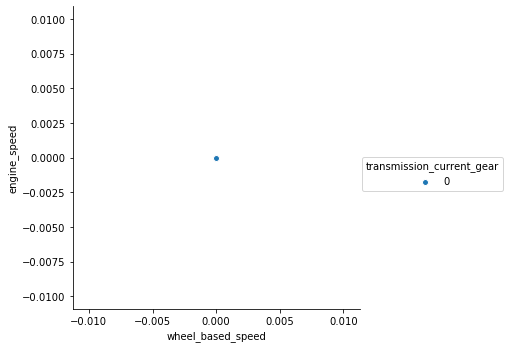

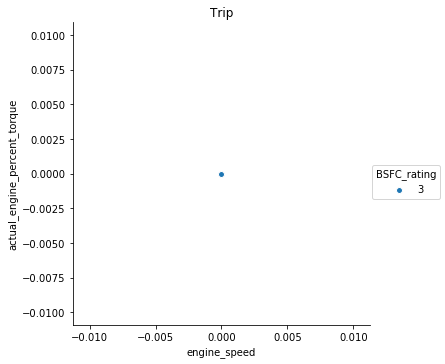

Average engine speed:  0.0  rpm
Average vehicle speed:  0.0  kmph
Red zone counts:  0  times
Max gear util:  nan  %
BSFC zone 0 % : 0.0
BSFC zone 1 % : 0.0
BSFC zone 2 % : 0.0
BSFC zone 3 % : 100.0
BSFC zone 4 % : 0.0
BSFC zone 5 % : 0.0
trip_distance : 0.0


C:\Users\devanandh.v\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


In [24]:
plot_trip_info(trip[4])

In [25]:
trip[4].vehicle_distance.describe()

count    19.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: vehicle_distance, dtype: float64

In [26]:
trip[5].wheel_based_speed

0     0.00
1     0.00
2     0.00
3     0.00
4     2.20
      ... 
63    2.69
64    4.43
65    4.40
66    2.63
67    0.00
Name: wheel_based_speed, Length: 68, dtype: float64